# Lead Classifier Using Pre-trained Transformers

## Introduction

The goal is to classify leads using pre-trained transformers, This approach uses embeddings from transformers and feeding them as inputs to feed forward network.

### Importing Required Libraries and Loading Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
nlp = spacy.load('en_core_web_sm')

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
tf.__version__

'2.17.0'

In [5]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = TFAutoModel.from_pretrained('bert-base-uncased')

d:\Agents\Lead_generator\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Agents\Lead_generator\my_env\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
from keras.utils import to_categorical

In [7]:
import imblearn
from imblearn.over_sampling import SMOTE

In [8]:
df = pd.read_csv('../data/raw/leads_dataset.csv', header = 0)

### Data Exploration

In [9]:
df.head()

,Company,Website,Industry,Address Street,City,State,Zip Code,Country,Contact Number,First Name,Last Name,Job Title,Email,Linkedin URL
0,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,443 West Alameda Drive,Tempe,Arizona,85282,United States,1 480 966 1215,Leanne,Wilhardt,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/
1,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,2000 Nw 133Rd Ave #2Miami,Miami,Florida,33182,United States,1 786 409 2101,Ron,Plantz,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/
2,Ada Med Supply Limited,adamedicalsupply.com,Retail,NaN,Sandy Springs,Georgia,30328,United States,1 678 398 0505,Aniedi,James,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/
3,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,6800 Nw 77Th Ct Miami,Miami,Florida,33166,United States,1 305 477 6331,Rafael,Celli,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/
4,Aims Inc,aims1.com,Software Development,235 Desiard Street,Monroe,Los Angeles,71201,United States,1 318 323 2467,Robert,Canterbury,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/


In [10]:
df.shape

(101, 14)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Company         101 non-null    object
 1   Website         101 non-null    object
 2   Industry        101 non-null    object
 3   Address Street  100 non-null    object
 4   City            100 non-null    object
 5   State           101 non-null    object
 6   Zip Code        101 non-null    int64 
 7   Country         101 non-null    object
 8   Contact Number  101 non-null    object
 9   First Name      101 non-null    object
 10  Last Name       101 non-null    object
 11  Job Title       101 non-null    object
 12  Email           101 non-null    object
 13  Linkedin URL    101 non-null    object
dtypes: int64(1), object(13)
memory usage: 11.2+ KB


In [12]:
df.isnull().sum()

Company           0
Website           0
Industry          0
Address Street    1
City              1
State             0
Zip Code          0
Country           0
Contact Number    0
First Name        0
Last Name         0
Job Title         0
Email             0
Linkedin URL      0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df['Job Title'].value_counts()

Job Title
Chief Executive Officer                       45
President                                     27
Founder                                        5
General Manager                                4
Vice President                                 3
Owner                                          3
Executive Director                             2
Managing Director                              2
Director                                       2
CoOwner                                        1
CoFounder                                      1
Executive Vice President                       1
Vice President Clinical Market Development     1
Global Industry Director                       1
International Director                         1
Deputy Director                                1
Vice President of Operations                   1
Name: count, dtype: int64

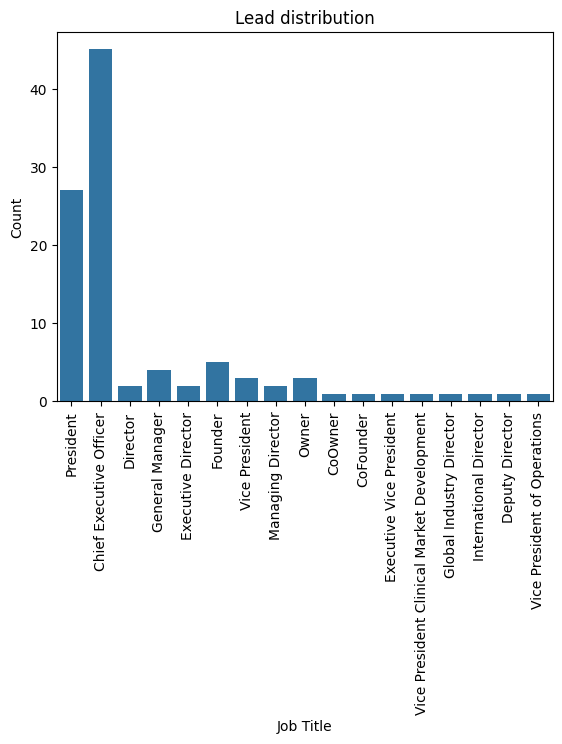

In [15]:
sns.countplot(data=df, x= 'Job Title')
plt.xlabel('Job Title')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Lead distribution')
plt.show()

### Data Preprocessing Using Spacy

In [16]:
df['Name'] = df['First Name']+ ' ' + df['Last Name']

In [17]:
first_col = df.pop('Name')
df.insert(0,'Name',first_col)
df.head()

,Name,Company,Website,Industry,Address Street,City,State,Zip Code,Country,Contact Number,First Name,Last Name,Job Title,Email,Linkedin URL
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,443 West Alameda Drive,Tempe,Arizona,85282,United States,1 480 966 1215,Leanne,Wilhardt,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,2000 Nw 133Rd Ave #2Miami,Miami,Florida,33182,United States,1 786 409 2101,Ron,Plantz,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,NaN,Sandy Springs,Georgia,30328,United States,1 678 398 0505,Aniedi,James,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,6800 Nw 77Th Ct Miami,Miami,Florida,33166,United States,1 305 477 6331,Rafael,Celli,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,235 Desiard Street,Monroe,Los Angeles,71201,United States,1 318 323 2467,Robert,Canterbury,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/


In [18]:
df = df.drop(['Address Street', 'Country', 'Zip Code', 'Contact Number', 'City', 'State','First Name', 'Last Name'], axis = 1)

In [19]:
df.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/


In [20]:
df_spacy = df.copy()

In [21]:
df_spacy.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/


In [22]:
def spacy_preprocess(text):
    words = nlp(text.lower())
    words = [word.text for word in words if word.text.isalnum()]
    return ' '.join(words)

In [23]:
df_spacy['processed job_title'] = df_spacy['Job Title'].apply(spacy_preprocess)


In [24]:
df_spacy['processed Company_name'] = df_spacy['Company'].apply(spacy_preprocess)

In [25]:
df_spacy['processed Industry_name'] = df_spacy['Industry'].apply(spacy_preprocess)

In [26]:
df_spacy['processed Name'] = df_spacy['Name'].apply(spacy_preprocess)

In [27]:
df_spacy.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,processed Name
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/,president,21st century healthcare inc,manufacturing,leanne wilhardt
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/,chief executive officer,aa medical store,medical equipment manufacturing,ron plantz
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/,president,ada med supply limited,retail,aniedi james
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/,president,advanced instrumentations inc,biotechnology research,rafael celli
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/,president,aims inc,software development,robert canterbury


## Vectorize the Data

Loading pre-trained transformer model and also tokenizer
for this we will be using TFAutoModel and AutoTokenizer instead of going for an transformer specific tokenizer and model so that we can implement same using another transformer without changing the code much later

In [28]:
def encode_feature(req_feature):
    #tokenizing
    inputs = tokenizer(req_feature, return_tensors='tf',truncation = True, padding = 'max_length', max_length = 20)
    outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:]

    return cls_embedding.numpy().flatten()

def combine_embeddings(embedding_col1,embedding_col2):
    return tf.concat([embedding_col1, embedding_col2], axis=0)  # Concatenate embeddings

In [29]:
df_spacy['job_title_feature_encoding'] = df_spacy['processed job_title'].apply(encode_feature)
df_spacy['Industry_feature_encoding'] = df_spacy['processed Industry_name'].apply(encode_feature)

In [30]:
df_spacy['combined_embeddings'] = df_spacy.apply(lambda row: combine_embeddings(row['job_title_feature_encoding'], row['Industry_feature_encoding']), axis=1)

In [31]:
df_spacy.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,processed Name,job_title_feature_encoding,Industry_feature_encoding,combined_embeddings
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/,president,21st century healthcare inc,manufacturing,leanne wilhardt,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.44714177, 0.2072348, -0.2586438, -0.258063...","(tf.Tensor(-0.53009087, shape=(), dtype=float3..."
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/,chief executive officer,aa medical store,medical equipment manufacturing,ron plantz,"[-0.5166925, 0.13698275, -0.21617708, 0.091861...","[-0.2998284, 0.18884052, -1.0831927, -0.320566...","(tf.Tensor(-0.5166925, shape=(), dtype=float32..."
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/,president,ada med supply limited,retail,aniedi james,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.2644915, 0.020314414, -0.23779479, -0.3004...","(tf.Tensor(-0.53009087, shape=(), dtype=float3..."
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/,president,advanced instrumentations inc,biotechnology research,rafael celli,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[0.025510872, 0.105550475, -0.8422301, -0.0477...","(tf.Tensor(-0.53009087, shape=(), dtype=float3..."
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/,president,aims inc,software development,robert canterbury,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.11512597, 0.1682517, -0.6216314, 0.0423190...","(tf.Tensor(-0.53009087, shape=(), dtype=float3..."


In [32]:
df_spacy['combined_embeddings'][0]

<tf.Tensor: shape=(1536,), dtype=float32, numpy=
array([-0.53009087,  0.36041957, -0.10122657, ..., -0.12748411,
        0.21734296,  0.20955475], dtype=float32)>

In [33]:
#convert all the embeddings to tensor for model input
features = tf.convert_to_tensor(np.stack(df_spacy['combined_embeddings'].values))


In [34]:
features

<tf.Tensor: shape=(101, 1536), dtype=float32, numpy=
array([[-0.53009087,  0.36041957, -0.10122657, ..., -0.12748411,
         0.21734296,  0.20955475],
       [-0.5166925 ,  0.13698275, -0.21617708, ..., -0.10543523,
         0.620227  , -0.11819591],
       [-0.53009087,  0.36041957, -0.10122657, ..., -0.1854208 ,
         0.40109605,  0.44042632],
       ...,
       [-0.53009087,  0.36041957, -0.10122657, ..., -0.10543523,
         0.620227  , -0.11819591],
       [-0.5166925 ,  0.13698275, -0.21617708, ..., -0.10543523,
         0.620227  , -0.11819591],
       [-0.7710692 ,  0.1360511 , -0.41925907, ..., -0.25043863,
        -0.13108745,  0.2567986 ]], dtype=float32)>

In [35]:
features.shape

TensorShape([101, 1536])

## Model Training and Evaluation

In [36]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape = (1536,)))
model.add(layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))  # For multi-class classification
loss = 'sparse_categorical_crossentropy'
optimizer = Adam(learning_rate=0.001)  # Adjust learning rate if necessary
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

d:\Agents\Lead_generator\my_env\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 919,043 (3.51 MB)

 Trainable params: 919,043 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
df_spacy.columns

Index(['Name', 'Company', 'Website', 'Industry', 'Job Title', 'Email',
       'Linkedin URL', 'processed job_title', 'processed Company_name',
       'processed Industry_name', 'processed Name',
       'job_title_feature_encoding', 'Industry_feature_encoding',
       'combined_embeddings'],
      dtype='object')

Dividing the industries and job titles into different categories for this use case

In [38]:
hot_industries = ['IT Services And IT Consulting', 'Software Development', 'Medical Device', 'Pharmaceuticals', 'Business Consulting And Services']
warm_industries = ['Hospitals And Health Care', 'Health, Wellness & Fitness', 'Nonprofit Organizations', 'Government Administration', 'Manufacturing']
cold_industries = ['Retail', 'Appliances, Electrical, And Electronics Manufacturing', 'Environmental Services', 'Design Services', 'Wholesale']

hot_job_titles = ['Chief Executive Officer', 'President', 'Founder', 'Vice President', 'Director']
warm_job_titles = ['Executive Director', 'Managing Director', 'Owner', 'General Manager', 'Vice President of Operations']
cold_job_titles = ['CoOwner', 'Deputy Director', 'Executive Vice President']

def classify_lead(row):
    if row['Job Title'] in hot_job_titles and row['Industry'] in hot_industries:
        return 'Hot'
    elif row['Job Title'] in warm_job_titles and row['Industry'] in warm_industries:
        return 'Warm'
    else:
        return 'Cold'

df_spacy['lead_type'] = df_spacy.apply(classify_lead, axis=1)

lead_type_mapping = {'Hot': 2, 'Warm': 1, 'Cold': 0}

df_spacy['lead_label'] = df_spacy['lead_type'].map(lead_type_mapping)


In [39]:
df_spacy.head()

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,processed Name,job_title_feature_encoding,Industry_feature_encoding,combined_embeddings,lead_type,lead_label
0,Leanne Wilhardt,"21st Century Healthcare, Inc",21stcenturyvitamins.com,Manufacturing,President,leannew@21stcenturyvitaminscom,https://wwwlinkedincom/in/leannewilhardt94513b15/,president,21st century healthcare inc,manufacturing,leanne wilhardt,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.44714177, 0.2072348, -0.2586438, -0.258063...","(tf.Tensor(-0.53009087, shape=(), dtype=float3...",Cold,0
1,Ron Plantz,Aa Medical Store,aamedicalstore.com,Medical Equipment Manufacturing,Chief Executive Officer,ronplantz@authorizedacquisitionscom,https://wwwlinkedincom/in/ronplantz9a394319/,chief executive officer,aa medical store,medical equipment manufacturing,ron plantz,"[-0.5166925, 0.13698275, -0.21617708, 0.091861...","[-0.2998284, 0.18884052, -1.0831927, -0.320566...","(tf.Tensor(-0.5166925, shape=(), dtype=float32...",Cold,0
2,Aniedi James,Ada Med Supply Limited,adamedicalsupply.com,Retail,President,aniedi@adamedicalsupplycom,https://wwwlinkedincom/in/aniedijames054a9585/,president,ada med supply limited,retail,aniedi james,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.2644915, 0.020314414, -0.23779479, -0.3004...","(tf.Tensor(-0.53009087, shape=(), dtype=float3...",Cold,0
3,Rafael Celli,"Advanced Instrumentations, Inc",advanced-inst.com,Biotechnology Research,President,rafael@advancedinstcom,https://wwwlinkedincom/in/rafaelcellia97058163/,president,advanced instrumentations inc,biotechnology research,rafael celli,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[0.025510872, 0.105550475, -0.8422301, -0.0477...","(tf.Tensor(-0.53009087, shape=(), dtype=float3...",Cold,0
4,Robert Canterbury,Aims Inc,aims1.com,Software Development,President,rcanterbury@aims1com,https://wwwlinkedincom/in/robertcanterburyaims/,president,aims inc,software development,robert canterbury,"[-0.53009087, 0.36041957, -0.10122657, 0.05373...","[-0.11512597, 0.1682517, -0.6216314, 0.0423190...","(tf.Tensor(-0.53009087, shape=(), dtype=float3...",Hot,2


In [40]:
df_spacy[['Job Title', 'Industry', 'lead_type']].head()


,Job Title,Industry,lead_type
0,President,Manufacturing,Cold
1,Chief Executive Officer,Medical Equipment Manufacturing,Cold
2,President,Retail,Cold
3,President,Biotechnology Research,Cold
4,President,Software Development,Hot


In [41]:
X = np.array([x for x in df_spacy['combined_embeddings']])
y = df_spacy['lead_label']

Splitting the data for feeding it to the model

In [42]:
# X: Features (e.g., combined embeddings)
# y: Labels (e.g., lead categories)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Training the model

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5000 - loss: 8.5591 - val_accuracy: 0.7500 - val_loss: 9.0550
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8750 - loss: 7.9694 - val_accuracy: 0.7500 - val_loss: 8.0615
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8646 - loss: 7.3497 - val_accuracy: 0.7500 - val_loss: 6.7968
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8646 - loss: 6.7085 - val_accuracy: 0.8750 - val_loss: 6.2876
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9167 - loss: 6.2271 - val_accuracy: 0.7500 - val_loss: 6.0901
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9062 - loss: 5.7131 - val_accuracy: 0.7500 - val_loss: 5.8098
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8750 - loss: 5.3325 - val_accuracy: 0.8750 - val_loss: 5.3218
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9688 - loss: 4.8720 - val_accuracy: 0.8750 - val_loss: 4.8

In [44]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9048 - loss: 4.2590
Test accuracy: 0.9047619104385376, Test loss: 4.259033203125


### Plotting the Data

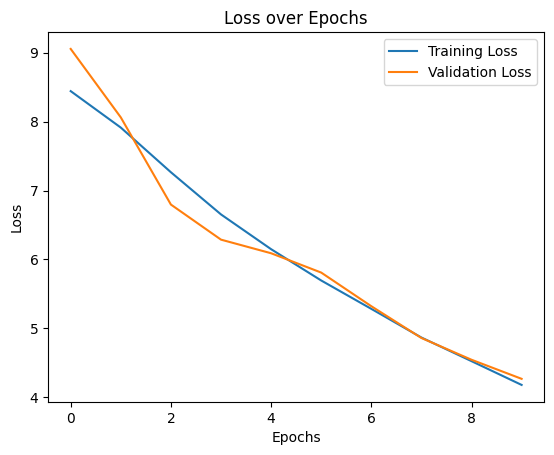

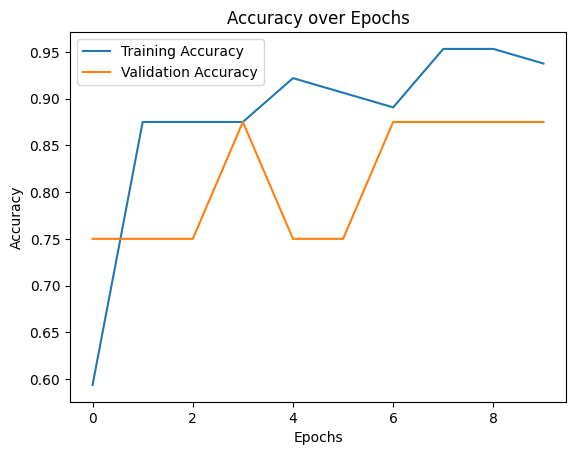

In [45]:
# Accessing history data
history.history.keys()  # This shows the metrics recorded, such as 'loss', 'accuracy', 'val_loss', 'val_accuracy'

# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


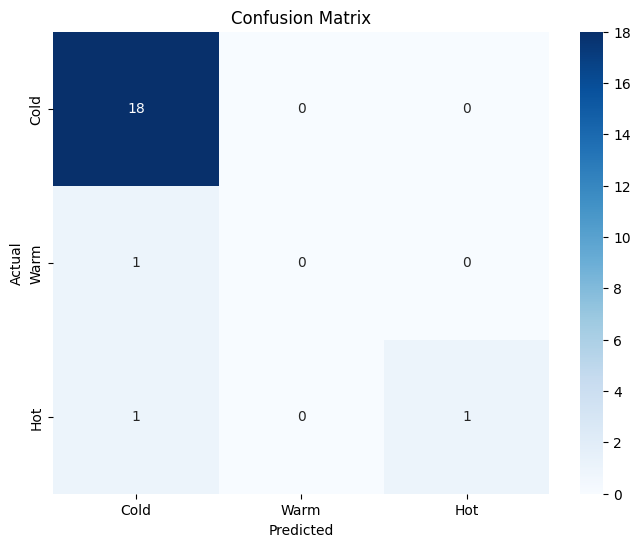

In [46]:
from sklearn.metrics import confusion_matrix

# Get the predicted classes
y_pred = model.predict(X_test).argmax(axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cold', 'Warm', 'Hot'], yticklabels=['Cold', 'Warm', 'Hot'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [47]:
y_test.value_counts()

lead_label
0    18
2     2
1     1
Name: count, dtype: int64

In [48]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



1/1 - 0s - 128ms/step - accuracy: 0.9048 - loss: 4.2590
Test Loss: 4.259033203125
Test Accuracy: 0.9047619104385376


In [49]:
var = df_spacy["combined_embeddings"][85]

In [50]:
x = np.array(var)  # Ensure x is a numpy array

# Reshape x to have a batch dimension
x = x.reshape(1, -1)  # Shape should be (1, feature_dim)

# Make prediction
print(model.predict(x))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
[[0.6111497  0.22780168 0.16104859]]


In [51]:
df_spacy.iloc[85]

Name                                                                     John H
Company                                                     Gojo Industries Inc
Website                                                                gojo.com
Industry                                                          Manufacturing
Job Title                                                                 Owner
Email                                                    johnahiggins3@gmailcom
Linkedin URL                  https://linkedincom/in/ACwAAAGHPXUBC7FbRdWTSLI...
processed job_title                                                       owner
processed Company_name                                      gojo industries inc
processed Industry_name                                           manufacturing
processed Name                                                           john h
job_title_feature_encoding    [-0.57602787, 0.034962088, -0.22704677, -0.387...
Industry_feature_encoding     [-0.447141

In [52]:
rslt_df = df_spacy.loc[df_spacy['lead_label'] == 1]
rslt_df

,Name,Company,Website,Industry,Job Title,Email,Linkedin URL,processed job_title,processed Company_name,processed Industry_name,processed Name,job_title_feature_encoding,Industry_feature_encoding,combined_embeddings,lead_type,lead_label
31,Mohamed Fajr,Aug Medical Llc,augmedical.com,Hospitals And Health Care,Executive Director,info@augmedicalcom,https://wwwlinkedincom/in/mohamedfajr/,executive director,aug medical llc,hospitals and health care,mohamed fajr,"[-0.608385, 0.14635035, -0.18327036, 0.0466570...","[0.18886527, 0.0853319, -0.13914324, 0.1031988...","(tf.Tensor(-0.608385, shape=(), dtype=float32)...",Warm,1
85,John H,Gojo Industries Inc,gojo.com,Manufacturing,Owner,johnahiggins3@gmailcom,https://linkedincom/in/ACwAAAGHPXUBC7FbRdWTSLI...,owner,gojo industries inc,manufacturing,john h,"[-0.57602787, 0.034962088, -0.22704677, -0.387...","[-0.44714177, 0.2072348, -0.2586438, -0.258063...","(tf.Tensor(-0.57602787, shape=(), dtype=float3...",Warm,1


Checking for class imbalance over unsatisfactory results

In [53]:
from collections import Counter
print(Counter(y))


Counter({0: 86, 2: 13, 1: 2})


### Trying to Balance the data to address the issues

In [54]:
# Initialize SMOTE for oversampling
smote = SMOTE(random_state=42, k_neighbors=1)  # Set k_neighbors based on your class size

# Apply SMOTE to the training data (ensure labels are not one-hot encoded)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

print(f"Original dataset shape: {X_train.shape}")
print(f"Resampled dataset shape: {X_train_resampled.shape}")

Original dataset shape: (80, 1536)
Resampled dataset shape: (258, 1536)


In [55]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [56]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6061 - loss: 4.7915 - val_accuracy: 0.7143 - val_loss: 3.6534
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6853 - loss: 3.5399 - val_accuracy: 0.9762 - val_loss: 2.7465
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.8901 - loss: 2.6967 - val_accuracy: 0.9762 - val_loss: 2.2058
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9077 - loss: 2.2566 - val_accuracy: 0.9762 - val_loss: 1.8767
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9581 - loss: 1.8284 - val_accuracy: 1.0000 - val_loss: 1.5351
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9675 - loss: 1.5624 - val_accuracy: 0.9762 - val_loss: 1.3681
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9425 - loss: 1.3908 - val_accuracy: 1.0000 - val_loss: 1.1416
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9828 - loss: 1.1623 - val_accuracy: 0.9762 - val_loss: 1.0405

In [57]:
var = df_spacy["combined_embeddings"][31]

In [58]:
x = np.array(var)  # Ensure x is a numpy array

# Reshape x to have a batch dimension
x = x.reshape(1, -1)  # Shape should be (1, feature_dim)

res = model.predict(x)
# Make prediction

for element in res.flatten():
    print(f"{float(element):.2%}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
22.74%
77.26%
0.00%


In [59]:
df_spacy["lead_label"][31]

1

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test_resampled, y_test_resampled, verbose=2)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


### Summarizing the Results

The embeddings are taken from the pre-trained transformer and fed to a feed forward neural network for classifying the leads.
The preprocessing was done using spaCy, the model trained and results were studied. Hyperparameter tuning was done to get better results. On unsatisfactory results post hyperparameter tuning the dataset was looked up on again for class imbalance. SMOTE Method was applied and then the model was trained again which yielded better results

Furthermore, the complete classification by fine tuning the pre-trained transformers has been made in approach 2.